In [ ]:
'''
Import helper_functions 
'''
from helper_functions import (split_X_y, split_num_cat, forecasting_result, show_scores, APE, plot_histogram, 
                              fill_na_inf, calculating_kWh, plot_kWh, loss_acc_epochs, plot_pv, 
                              model_checkpoint, early_stop)

2024-11-28 14:44:35.231192: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 14:44:35.603169: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-28 14:44:35.603213: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-28 14:44:35.604970: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 14:44:35.812788: I tensorflow/core/platform/cpu_feature_g

# Import historical dataset

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

original_df = pd.read_csv('../Dataset/hist_data.csv', 
                 index_col='timestamp_local', encoding='utf-8-sig', parse_dates=['timestamp_local'])

original_df.shape

(128832, 26)

In [5]:
'''
====================================
The imported dataset is already passed two preprocessing steps 

1. Remove timesteps with zero PV power output during daytime
2. Add sun position angles
====================================
'''
original_df.head(2)

,precip_rate,rh,wind_spd,timestamp_utc,snow_rate,app_temp,pres,azimuth,dewpt,uv,...,vis,dni,temp,slp,clouds,ts,PV_Power,declination_angle,altitude_angle,azimuth_angle
timestamp_local,,,,,,,,,,,,,,,,,,,,,
2016-01-04 00:00:00,0.0,61.0,1.6,2016-01-03 17:00:00,0.0,28.2,1014.76575,209.44,18.8,0.0,...,10.0,0.0,27.0,1015.0,25.0,1.451840e+09,0.0,-0.39703,-1.41642,0.00000
2016-01-04 00:15:00,0.0,63.0,1.6,2016-01-03 17:15:00,0.0,28.3,1014.76570,191.08,19.4,0.0,...,10.0,0.0,27.0,1015.0,25.0,1.451841e+09,0.0,-0.39703,-1.40442,0.37278


# Preprocessing data
### 1. Filter daytime timestamp

In [7]:
dt_fil_df = original_df[(original_df.index.time >= datetime.time(6,0)) & (original_df.index.time <= datetime.time(18,0))]
dt_fil_df.shape

(65758, 26)

In [9]:
print(f'Daytime filter has {dt_fil_df.shape[0]} samples, presenting {(dt_fil_df.shape[0] * 100 / original_df.shape[0]):.2f} % from original df')
print(f'Daytime filter df has {dt_fil_df.loc["2016-01-04"].shape[0]} samples per day')
df = dt_fil_df

Daytime filter has 65758 samples, presenting 51.04 % from original df
Daytime filter df has 49 samples per day


### 2. Features selections and arrange columns to extract spatial features 

In [10]:
'''
Arrange correlated columns:
`Irradiance` => `Temperatures` => `visibility` => 'Wind & humidity' => 'Sun Position' => 'PV_Power (y)' => Unused columns
'''
arr_cols = ['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh',       
            'app_temp', 'temp', 'dewpt', 
            'clouds', 'vis',             
            'wind_spd', 'wind_dir', 
            'declination_angle', 'altitude_angle', 'azimuth_angle',
            'PV_Power',
            'weather', 'precip_rate',   'timestamp_utc', 'snow_rate', 'pres', 'azimuth', 'elev_angle', 'slp', 'ts']

df = df[arr_cols]
df.columns

Index(['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh', 'app_temp', 'temp',
       'dewpt', 'clouds', 'vis', 'wind_spd', 'wind_dir', 'declination_angle',
       'altitude_angle', 'azimuth_angle', 'PV_Power', 'weather', 'precip_rate',
       'timestamp_utc', 'snow_rate', 'pres', 'azimuth', 'elev_angle', 'slp',
       'ts'],
      dtype='object')

In [11]:
# Split X columns into categorical and numerical 
categorical_columns, numerical_columns = split_num_cat(df)
print(f'Categorical columns : {categorical_columns} \n')
print(f'Numerical columns : {numerical_columns}')

Categorical columns : ['weather', 'timestamp_utc'] 

Numerical columns : ['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh', 'app_temp', 'temp', 'dewpt', 'clouds', 'vis', 'wind_spd', 'wind_dir', 'declination_angle', 'altitude_angle', 'azimuth_angle', 'PV_Power', 'precip_rate', 'snow_rate', 'pres', 'azimuth', 'elev_angle', 'slp', 'ts']


In [12]:
'''
Disgard columns which will not be used for forecasting
'''
y_col = ['PV_Power']

ignored_cols = ['dewpt', 'clouds', 'vis', 'precip_rate', 'azimuth', 'elev_angle', 
                'snow_rate', 'ts', 'pres', 'wind_dir', 'slp'] + categorical_columns 
print(f'Ignored columns : {ignored_cols}')

Ignored columns : ['dewpt', 'clouds', 'vis', 'precip_rate', 'azimuth', 'elev_angle', 'snow_rate', 'ts', 'pres', 'wind_dir', 'slp', 'weather', 'timestamp_utc']


In [13]:
# Split datasets by time
training_set = df.sort_index().loc[:'2018-09'] # Training set (2 years and 9 months) = 68%
val_set = df.sort_index().loc['2018-10':'2018-12'] # Validation set (3 months) = 7%
test_set = df.sort_index().loc['2019':] # Test set (1 year) = 25%

# Split `X` and `y`
X_train, y_train = split_X_y(training_set, ignored_cols)
X_val, y_val = split_X_y(val_set, ignored_cols)
X_test, y_test = split_X_y(test_set, ignored_cols)

X_cols = X_train.columns
print(f'List of X columns: \n{list(X_cols)} \n')
print(f'Total of X columns: \n{len(X_cols)}')

List of X columns: 
['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh', 'app_temp', 'temp', 'wind_spd', 'declination_angle', 'altitude_angle', 'azimuth_angle'] 

Total of X columns: 
12


In [14]:
## Time peroid of each dataset. 
print(
    f'''
    Training set is from {X_train.index.min()} to {X_train.index.max()} 
    Validation set is from {X_val.index.min()} to {X_val.index.max()} 
    Test set is from {X_test.index.min()} to {X_test.index.max()}
    ''')


    Training set is from 2016-01-04 06:00:00 to 2018-09-30 18:00:00 
    Validation set is from 2018-10-01 06:00:00 to 2018-12-31 18:00:00 
    Test set is from 2019-01-01 06:00:00 to 2019-12-31 18:00:00
    


### 3. Rescale numerical columns

In [16]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler

# Manage columns for Standardize processes
non_std_cols = ['declination_angle', 'altitude_angle', 'azimuth_angle']

selected_cols = list(map(lambda x : x not in non_std_cols, X_cols))
std_cols = X_cols[selected_cols]
print(f'Total of columns to rescale: {len(std_cols)} columns')
print(f'Columns to rescale are: {list(std_cols)} \n')

ct = make_column_transformer((MaxAbsScaler(), std_cols), remainder='passthrough')

ct.fit(X_train)

std_X_train = ct.transform(X_train)
std_X_val = ct.transform(X_val)
std_X_test = ct.transform(X_test)

std_X_train.shape, y_train.shape, std_X_val.shape, y_val.shape, std_X_test.shape, y_test.shape

Total of columns to rescale: 9 columns
Columns to rescale are: ['solar_rad', 'ghi', 'dhi', 'dni', 'uv', 'rh', 'app_temp', 'temp', 'wind_spd'] 



((44982, 12), (44982,), (4312, 12), (4312,), (16464, 12), (16464,))

In [17]:
'''
Check data type of all dataset
'''
std_X_train.dtype, y_train.dtype, std_X_val.dtype, y_val.dtype, std_X_test.dtype, y_test.dtype

(dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'),
 dtype('float32'))

In [18]:
print(f"training set = {np.round(std_X_train.shape[0] / df.shape[0], 2)}")
print(f"validation set = {np.round(std_X_val.shape[0] / df.shape[0], 2)}")
print(f"test set = {np.round(std_X_test.shape[0] / df.shape[0], 2)}")
print(f'total datapoints = {std_X_train.shape[0] + std_X_val.shape[0] + std_X_test.shape[0]}')

training set = 0.68
validation set = 0.07
test set = 0.25
total datapoints = 65758


In [19]:
'''
Testing normalize process
'''
print(f'Total samples in a day = {df.loc["2016-01-04"].shape[0]}')

Total samples in a day = 49


# Setup environment
### 1. Check CPU and GPU available

In [20]:
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version = " + tf.__version__)

Num GPUs Available:  1
Tensorflow version = 2.14.0


2024-11-28 14:56:33.242242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-28 14:56:33.582730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-28 14:56:33.582782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


### 2. Set random seed and state

In [21]:
import os, random
import tensorflow as tf

def set_seed(seed_value=20):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

# Building forecast models

### 1. Multilayers Perceptron (MLP)

In [22]:
from keras import Model
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Activation, Input
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.metrics import RootMeanSquaredError

set_seed()

# model structure
inputs = Input(shape=(std_X_train.shape[1]), name='model_input')

x = Dense(96, activation='relu', name='1st_dense')(inputs)
x = BatchNormalization()(x)
x = Dense(48, activation='relu', name='2nd_dense')(x)
x = BatchNormalization()(x)
x = Dense(24, activation='tanh', name='3rd_dense')(x)
x = BatchNormalization()(x)

output = Dense(1, activation='relu', name='model_output')(x)
MLP_model = Model(inputs=inputs, outputs=output, name='MLP_model')

# Configure optimizer
lr_scheduler = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_rate=1e-6, decay_steps=1, staircase=False)
opt = Adam(learning_rate=lr_scheduler)

# Define an optimizer and loss metric
MLP_model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mean_absolute_error'])

MLP_model.summary()

2024-11-28 14:58:37.910409: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-28 14:58:37.910496: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-28 14:58:37.910524: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-28 14:58:38.229301: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-28 14:58:38.229363: I tensorflow/compile

Model: "MLP_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_input (InputLayer)    [(None, 12)]              0         
                                                                 
 1st_dense (Dense)           (None, 96)                1248      
                                                                 
 batch_normalization (Batch  (None, 96)                384       
 Normalization)                                                  
                                                                 
 2nd_dense (Dense)           (None, 48)                4656      
                                                                 
 batch_normalization_1 (Bat  (None, 48)                192       
 chNormalization)                                                
                                                                 
 3rd_dense (Dense)           (None, 24)                11

In [23]:
'''
===================
Initial train model 
===================
'''
init_epochs = 30
Batch = 32

with tf.device('/GPU:0'):
    MLP_history = MLP_model.fit(x=std_X_train, y=y_train, 
                                epochs=init_epochs, batch_size=Batch, 
                                validation_data=(std_X_val, y_val), verbose=1,
                                callbacks=[early_stop('val_loss', 5)])

Epoch 1/30


2024-11-28 15:00:38.238570: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2df47ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-28 15:00:38.238611: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-11-28 15:00:38.251586: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-28 15:00:38.319965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-28 15:00:38.423701: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1406/1406 [==============================] - 14s 8ms/step - loss: 2920.6267 - mean_absolute_error: 2920.6267 - val_loss: 2368.7483 - val_mean_absolute_error: 2368.7483
Epoch 2/30
1406/1406 [==============================] - 11s 8ms/step - loss: 2677.1619 - mean_absolute_error: 2677.1619 - val_loss: 2112.2595 - val_mean_absolute_error: 2112.2595
Epoch 3/30
1406/1406 [==============================] - 11s 8ms/step - loss: 2299.3821 - mean_absolute_error: 2299.3821 - val_loss: 1684.1504 - val_mean_absolute_error: 1684.1504
Epoch 4/30
1406/1406 [==============================] - 11s 8ms/step - loss: 1864.2992 - mean_absolute_error: 1864.2992 - val_loss: 1274.0807 - val_mean_absolute_error: 1274.0807
Epoch 5/30
1406/1406 [==============================] - 11s 8ms/step - loss: 1412.2815 - mean_absolute_error: 1412.2815 - val_loss: 953.4762 - val_mean_absolute_error: 953.4762
Epoch 6/30
1406/1406 [==============================] - 11s 8ms/step - loss: 1058.1217 - mean_absolute_error: 1058.121

#### Evaluate forecast results

In [27]:
MLP_val_result = forecasting_result(MLP_model, std_X_val)
MLP_test_result = forecasting_result(MLP_model, std_X_test)

515/515 [==============================] - 1s 2ms/step


In [ ]:
# Evaluate scores on the validation dataset
MLP_val_scores = show_scores(MLP_val_result, y_val)

Mean Absolute Error = 618.11 W 
Root Mean Squared Error = 942.15 W 
Mean Bias Error = 355.70 W 
 
Normalized_MAE (installed_Power) = 6.18% 
Normalized_RMSE (installed_Power) = 9.42% 
 
Normalized_MAE (avg_Power) = 24.57% 
Normalized_RMSE (avg_Power) = 37.45% 
 
Peak PV output power (from y_test) = 7888.33 W 
Average PV output power (from y_test) = 2515.80 W


In [ ]:
# Evaluate scores on the test dataset
MLP_test_scores = show_scores(MLP_test_result, y_test)

Mean Absolute Error = 719.57 W 
Root Mean Squared Error = 1021.62 W 
Mean Bias Error = 200.55 W 
 
Normalized_MAE (installed_Power) = 7.20% 
Normalized_RMSE (installed_Power) = 10.22% 
 
Normalized_MAE (avg_Power) = 23.52% 
Normalized_RMSE (avg_Power) = 33.39% 
 
Peak PV output power (from y_test) = 9875.00 W 
Average PV output power (from y_test) = 3059.60 W


#### Plot loss curve

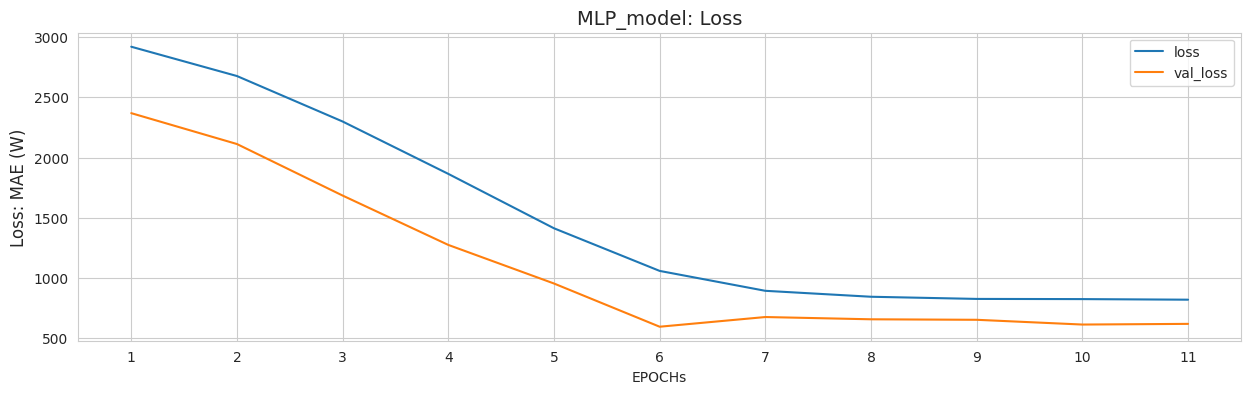

In [30]:
loss_acc_epochs(MLP_history, model_name='MLP_model', loss_name='MAE (W)')

### 2. RandomForest (RF)

In [31]:
from sklearn.ensemble import RandomForestRegressor
set_seed()
RF_model = RandomForestRegressor(n_jobs=-1, random_state=20, n_estimators=500, 
                                max_depth=10, min_samples_leaf=16,
                                min_samples_split=34)

In [32]:
RF_model.fit(std_X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=16, min_samples_split=34,
                      n_estimators=500, n_jobs=-1, random_state=20)

#### Evaluate forecast results

In [33]:
RF_val_result = forecasting_result(RF_model, std_X_val)
RF_test_result = forecasting_result(RF_model, std_X_test)

# Evaluate scores on the validation dataset
RF_val_scores = show_scores(RF_val_result, y_val)

Mean Absolute Error = 584.08 W 
Root Mean Squared Error = 923.69 W 
Mean Bias Error = 225.38 W 
 
Normalized_MAE (installed_Power) = 5.84% 
Normalized_RMSE (installed_Power) = 9.24% 
 
Normalized_MAE (avg_Power) = 23.22% 
Normalized_RMSE (avg_Power) = 36.72% 
 
Peak PV output power (from y_test) = 7888.33 W 
Average PV output power (from y_test) = 2515.80 W


In [34]:
# Evaluate scores on the test dataset
RF_test_scores = show_scores(RF_test_result, y_test)

Mean Absolute Error = 690.03 W 
Root Mean Squared Error = 1008.22 W 
Mean Bias Error = 58.85 W 
 
Normalized_MAE (installed_Power) = 6.90% 
Normalized_RMSE (installed_Power) = 10.08% 
 
Normalized_MAE (avg_Power) = 22.55% 
Normalized_RMSE (avg_Power) = 32.95% 
 
Peak PV output power (from y_test) = 9875.00 W 
Average PV output power (from y_test) = 3059.60 W


### 3. Support Vector Machine (SVM)

In [35]:
from sklearn.svm import LinearSVR
set_seed()
SVR_model = LinearSVR(C=5.0, epsilon=1.0)

In [36]:
SVR_model.fit(std_X_train, y_train)

/home/ball/miniconda3/envs/tf_gpu/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVR(C=5.0, epsilon=1.0)

#### Evaluate forecast results

In [37]:
SVR_val_result = forecasting_result(SVR_model, std_X_val)
SVR_test_result = forecasting_result(SVR_model, std_X_test)
# Evaluate scores on the validation dataset
SVR_val_scores = show_scores(SVR_val_result, y_val)

Mean Absolute Error = 691.08 W 
Root Mean Squared Error = 1012.07 W 
Mean Bias Error = 280.39 W 
 
Normalized_MAE (installed_Power) = 6.91% 
Normalized_RMSE (installed_Power) = 10.12% 
 
Normalized_MAE (avg_Power) = 27.47% 
Normalized_RMSE (avg_Power) = 40.23% 
 
Peak PV output power (from y_test) = 7888.33 W 
Average PV output power (from y_test) = 2515.80 W


In [38]:
# Evaluate scores on the test dataset
SVR_test_scores = show_scores(SVR_test_result, y_test)

Mean Absolute Error = 784.07 W 
Root Mean Squared Error = 1077.07 W 
Mean Bias Error = 112.13 W 
 
Normalized_MAE (installed_Power) = 7.84% 
Normalized_RMSE (installed_Power) = 10.77% 
 
Normalized_MAE (avg_Power) = 25.63% 
Normalized_RMSE (avg_Power) = 35.20% 
 
Peak PV output power (from y_test) = 9875.00 W 
Average PV output power (from y_test) = 3059.60 W


## Comparing the model's accuracy

In [39]:
NWP_model_scores = pd.DataFrame([MLP_test_scores, RF_test_scores, SVR_test_scores], 
                            index=['MLP', 'RF', 'SVM']).round(2)

NWP_model_scores

,MAE,RMSE,MBE,NMAE_installed,NRMSE_installed,NMAE_avg,NRMSE_avg
MLP,719.57,1021.62,200.55,7.20,10.22,23.52,33.39
RF,690.03,1008.22,58.85,6.90,10.08,22.55,32.95
SVM,784.07,1077.07,112.13,7.84,10.77,25.63,35.20


In [40]:
NWP_model_results = pd.concat([y_test.reset_index(), pd.Series(MLP_test_result),
                               pd.Series(RF_test_result), pd.Series(SVR_test_result)], axis=1)

NWP_model_results = NWP_model_results.set_index('timestamp_local')
NWP_model_results.columns = ['Actual', 'MLP', 'RandomForest', 'SVM']

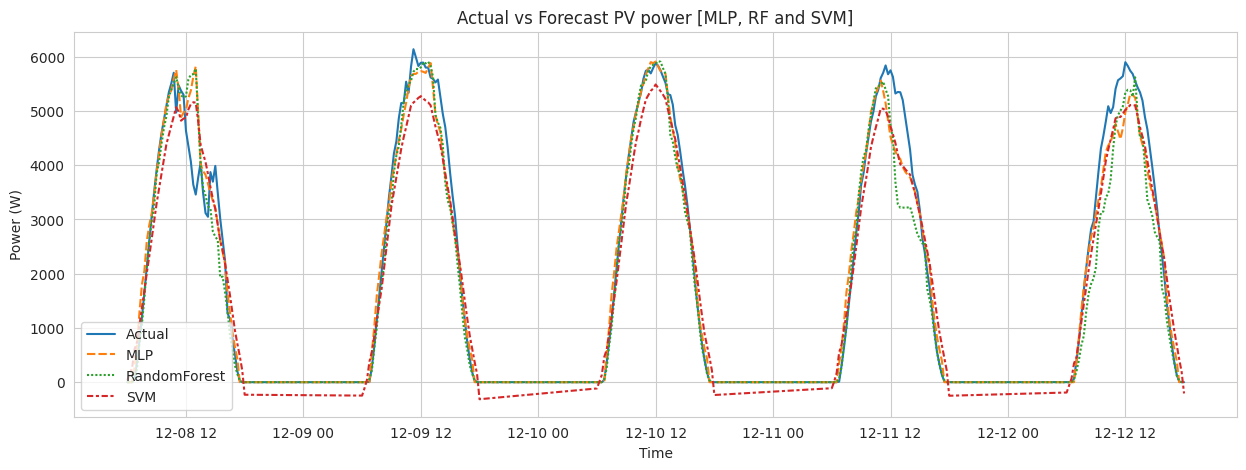

In [42]:
plt.figure(figsize=(15,5))
sns.lineplot(data=NWP_model_results['2019-12-08':'2019-12-12'])
plt.title('Actual vs Forecast PV power [MLP, RF and SVM]')
plt.xlabel('Time')
plt.ylabel('Power (W)');

# Test the three forecast models with Numerical Weather Prediction (NWP) data

In [48]:
ori_NWP_df = pd.read_csv('../Dataset/fore_data.csv', 
                         index_col='timestamp_local', encoding='utf-8-sig', parse_dates=['timestamp_local'])
ori_NWP_df.shape

(191, 35)

### Data preprocessing

In [49]:
'''
Daytime filter
'''
NWP_df = ori_NWP_df[(ori_NWP_df.index.time >= datetime.time(6,0)) & (ori_NWP_df.index.time <= datetime.time(18,0))]
NWP_df.shape

(104, 35)

In [50]:
'''
Split X and y
'''
NWP_X = NWP_df[X_cols]
NWP_y = NWP_df['PV_Power']
NWP_X.shape, NWP_y.shape

((104, 12), (104,))

In [51]:
'''
OneHot Encoding and Standardize numerical data
'''
std_NWP_X = ct.transform(NWP_X)
std_NWP_X.shape

(104, 12)

### Forecast PV power using NWP data

In [54]:
# MLP
fore_MLP_result = forecasting_result(MLP_model, std_NWP_X)
print(f'MLP forecast shape: {fore_MLP_result.shape}')

# Random Forest
fore_RF_result = forecasting_result(RF_model, std_NWP_X)
print(f'RF forecast shape: {fore_RF_result.shape}')

# SVR
fore_SVR_result = forecasting_result(SVR_model, std_NWP_X)
print(f'SVR forecast shape: {fore_SVR_result.shape}')

4/4 [==============================] - 0s 3ms/step
MLP forecast shape: (104,)
RF forecast shape: (104,)
SVR forecast shape: (104,)


In [57]:
'''
MLP model
'''
forecast_MLP_scores = show_scores(fore_MLP_result, NWP_y)

Mean Absolute Error = 813.47 W 
Root Mean Squared Error = 1094.55 W 
Mean Bias Error = 728.38 W 
 
Normalized_MAE (installed_Power) = 8.13% 
Normalized_RMSE (installed_Power) = 10.95% 
 
Normalized_MAE (avg_Power) = 26.00% 
Normalized_RMSE (avg_Power) = 34.98% 
 
Peak PV output power (from y_test) = 6623.48 W 
Average PV output power (from y_test) = 3128.71 W


In [58]:
'''
RF model
'''
forecast_RF_scores = show_scores(fore_RF_result, NWP_y)

Mean Absolute Error = 648.99 W 
Root Mean Squared Error = 903.13 W 
Mean Bias Error = 463.12 W 
 
Normalized_MAE (installed_Power) = 6.49% 
Normalized_RMSE (installed_Power) = 9.03% 
 
Normalized_MAE (avg_Power) = 20.74% 
Normalized_RMSE (avg_Power) = 28.87% 
 
Peak PV output power (from y_test) = 6623.48 W 
Average PV output power (from y_test) = 3128.71 W


In [59]:
'''
SVM model
'''
forecast_SVR_scores = show_scores(fore_SVR_result, NWP_y)

Mean Absolute Error = 746.33 W 
Root Mean Squared Error = 1000.28 W 
Mean Bias Error = 678.81 W 
 
Normalized_MAE (installed_Power) = 7.46% 
Normalized_RMSE (installed_Power) = 10.00% 
 
Normalized_MAE (avg_Power) = 23.85% 
Normalized_RMSE (avg_Power) = 31.97% 
 
Peak PV output power (from y_test) = 6623.48 W 
Average PV output power (from y_test) = 3128.71 W


## Comparing the model's accuracy on NWP data

In [60]:
score_table_forecast = pd.DataFrame([forecast_MLP_scores, forecast_RF_scores, forecast_SVR_scores], 
                                    index=['MLP','RandomForest', 'SVR'])
score_table_forecast

,MAE,RMSE,MBE,NMAE_installed,NRMSE_installed,NMAE_avg,NRMSE_avg
MLP,813.47,1094.55,728.38,8.13,10.95,26.00,34.98
RandomForest,648.99,903.13,463.12,6.49,9.03,20.74,28.87
SVR,746.33,1000.28,678.81,7.46,10.00,23.85,31.97


In [61]:
fore_data_results = pd.concat([NWP_y.reset_index(), pd.Series(fore_MLP_result), 
                            pd.Series(fore_RF_result), pd.Series(fore_SVR_result)], axis=1)

fore_data_results = fore_data_results.set_index('timestamp_local')
fore_data_results.columns = ['PV_Power', 'MLP', 'RandomForest', 'SVM']

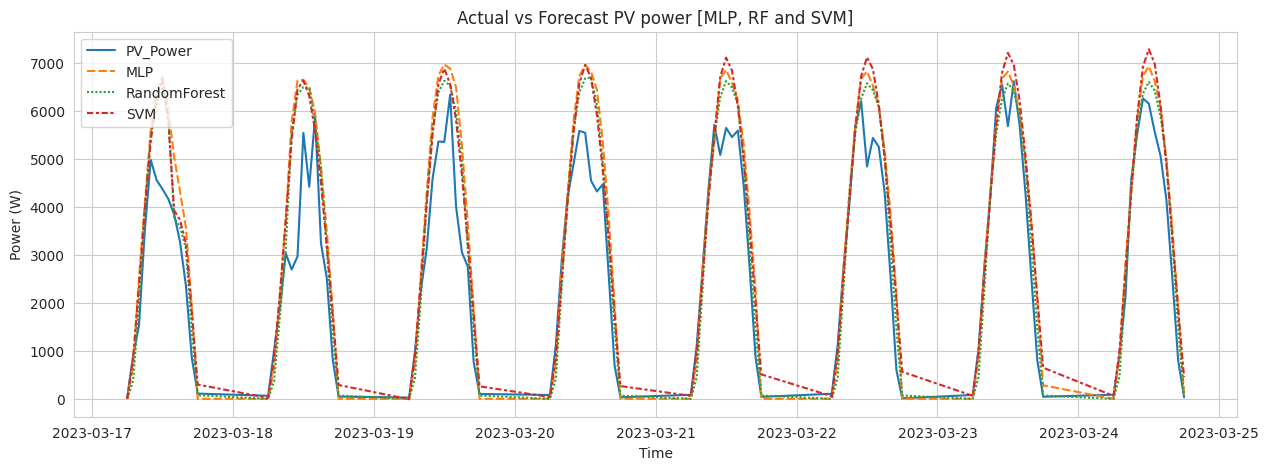

In [62]:
plt.figure(figsize=(15,5))
sns.lineplot(data=fore_data_results)
plt.title('Actual vs Forecast PV power [MLP, RF and SVM]')
plt.xlabel('Time')
plt.ylabel('Power (W)');

## Calculate Absolute Percentage Error (APE) between forecast and actual power

In [67]:
fore_data_results['APE_MLP'] = APE(fore_data_results['MLP'], fore_data_results['PV_Power'])
fore_data_results['APE_RF'] = APE(fore_data_results['RandomForest'], fore_data_results['PV_Power'])
fore_data_results['APE_SVM'] = APE(fore_data_results['SVM'], fore_data_results['PV_Power'])

Max APE = 548.97
Min APE = 0.01
Mean APE = 53.04
Median APE = 30.83


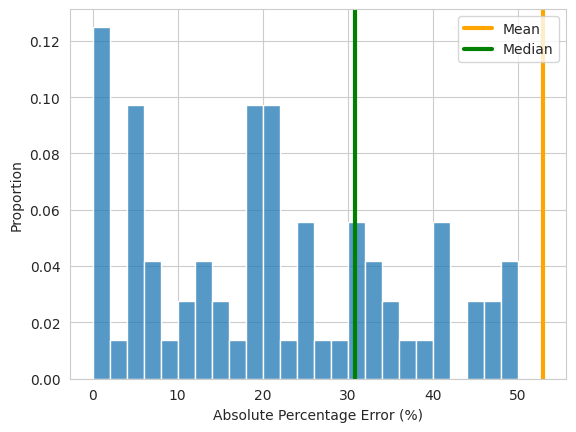

In [69]:
'''
MLP model
'''
plot_histogram(fore_data_results['APE_MLP'], 2, 50)
print(f'Max APE = {np.max(fore_data_results["APE_MLP"])}')
print(f'Min APE = {np.min(fore_data_results["APE_MLP"])}')
print(f'Mean APE = {np.mean(fore_data_results["APE_MLP"]):.2f}')
print(f'Median APE = {np.median(fore_data_results["APE_MLP"]):.2f}')

Max APE = 540.53
Min APE = 0.04
Mean APE = 42.49
Median APE = 23.93


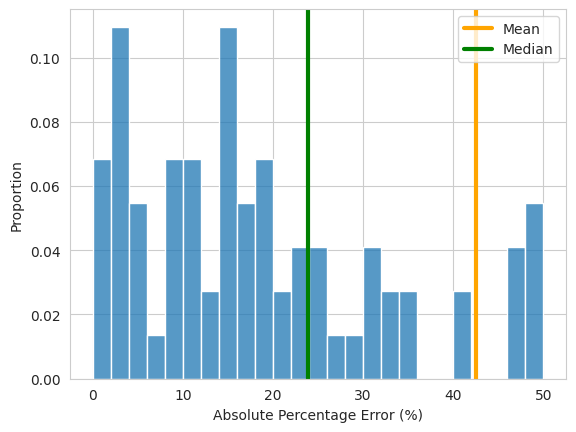

In [70]:
'''
RF model
'''
plot_histogram(fore_data_results['APE_RF'], 2, 50)
print(f'Max APE = {np.max(fore_data_results["APE_RF"])}')
print(f'Min APE = {np.min(fore_data_results["APE_RF"])}')
print(f'Mean APE = {np.mean(fore_data_results["APE_RF"]):.2f}')
print(f'Median APE = {np.median(fore_data_results["APE_RF"]):.2f}')

Max APE = 5096.54
Min APE = 0.09
Mean APE = 132.57
Median APE = 25.47


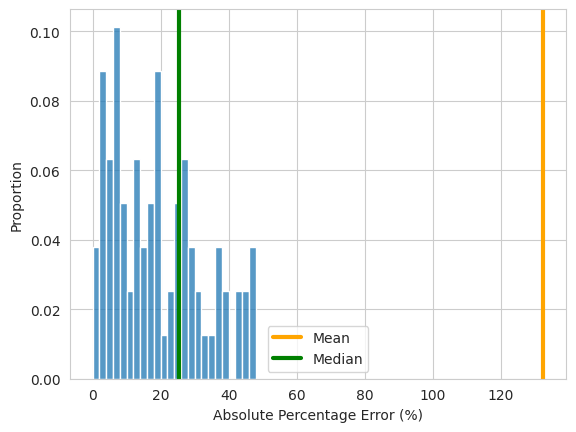

In [71]:
'''
SVM model
'''
plot_histogram(fore_data_results['APE_SVM'], 2, 50)

print(f'Max APE = {np.max(fore_data_results["APE_SVM"])}')
print(f'Min APE = {np.min(fore_data_results["APE_SVM"])}')
print(f'Mean APE = {np.mean(fore_data_results["APE_SVM"]):.2f}')
print(f'Median APE = {np.median(fore_data_results["APE_SVM"]):.2f}')